In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [2]:
# Calibrating the image
import numpy as np
import cv2
import glob
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib qt5

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         #write_name = 'corners_found'+str(idx)+'.jpg'
#         #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

In [3]:
# cs is short for color space
def cvt_color(img, cs):
    if cs[0] == 'gray':
        color = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif cs[0] == 'HLS':
        color = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        if cs[1] == 'H':
            color = color[:,:,0]
        elif cs[1] == 'L':
            color = color[:,:,1]
        else:
            color = color[:,:,2]
    return color
    
def abs_sobel_thresh(img, orient='x', cs=('gray', None), sobel_kernel=3, thresh=(0, 255)):
    color = cvt_color(img, cs)
    dx = (orient == 'x')
    dy = (orient == 'y')
    sobel = cv2.Sobel(color, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * (abs_sobel/np.max(abs_sobel)))

    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return grad_binary

def mag_thresh(img, cs=('gray', None), sobel_kernel=3, mag_thresh=(0, 255)):
    
    color = cvt_color(img, cs)
    sobelx = cv2.Sobel(color, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(color, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = np.uint8(255*(mag/np.max(mag)))
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag>=mag_thresh[0]) & (mag <=mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, cs=('gray', None), sobel_kernel=3, thresh=(0, np.pi/2)):
    color = cvt_color(img, cs)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    
    mask = np.zeros_like(dir_gradient)
    mask[(dir_gradient > thresh[0]) & (dir_gradient < thresh[1])] = 1
    
    return mask

In [4]:
def get_highest_in_x(start_point, histogram):
    dist = int((search_range - width) / 2)
    start = start_point - dist
    end = start_point + dist
    
    highest_range = []
    highest_range_arg = []
    
    for pos in range(start, end+1, stride):
        leftx = pos
        rightx = leftx + width
        highest_range.append(np.sum(histogram[leftx:rightx]))
        highest_range_arg.append((leftx, rightx))
    # print('highest left range is: ', highest_left_range)
    index = np.argmax(highest_range) # it's a range
    lane_pixel_pos = highest_range_arg[index][0]
    return lane_pixel_pos
    
    

def get_bottom_lane_marks(img):
    histogram = np.sum(img[2*int(img.shape[0]/3):,:], axis=0)
    middle = int(histogram.shape[0]/2)
    left_high = np.argmax(histogram[:middle])
    right_high = np.argmax(histogram[middle:]) + middle

    left_start_point = int(left_high - width/2)
    right_start_point = int(right_high - width/2)
    
    left_lane_pixel_pos = get_highest_in_x(left_start_point, histogram)
    right_lane_pixel_pos = get_highest_in_x(right_start_point, histogram)
    return left_lane_pixel_pos, right_lane_pixel_pos
    

def find_lane_patches(img, last_left_x, last_right_x, current_y):
    """ Given previous patch location, find best sliding window above it
        param: img, previous location width, height
        return: left start point of the maximum sliding window
    """
    histogram = np.sum(img[current_y: current_y + height,:], axis=0)
    left_lane_pixel_pos = get_highest_in_x(last_left_x, histogram)
    right_lane_pixel_pos = get_highest_in_x(last_right_x, histogram)
    
    return (left_lane_pixel_pos, right_lane_pixel_pos)

In [5]:
ksize = 15
# define some variables for sliding windows
offset = 200
offset_dst = 300
offset_top = 590
x = 1280
y = 720

# sliding windows constants
width = 120
height = 120
stride = 10
search_range = 300

# perspective transformation
trans = np.zeros((1, y, x))
src = np.float32([(offset_top, 450), (x-offset_top, 450), (x-offset, y), (offset, y)])
dst = np.float32([(offset_dst, 0), (x-offset_dst, 0), (x-offset_dst, y), (offset_dst, y)])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [21]:
def detect_lane_line(img):
    img_size = (img.shape[1], img.shape[0])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    # gradient and color space
    cs_s = ('HLS', 'S')
    gradx_s = abs_sobel_thresh(undistort, orient='x', cs=cs_s, sobel_kernel=ksize, thresh=(20, 100))
    grady_s = abs_sobel_thresh(undistort, orient='y', cs=cs_s, sobel_kernel=ksize, thresh=(20, 100))
    mag_binary_s = mag_thresh(undistort, cs=cs_s, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary_s = dir_threshold(undistort, cs=cs_s, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    cs_gray = ('gray', None)
    gradx_gray = abs_sobel_thresh(undistort, orient='x', cs=cs_gray, sobel_kernel=ksize, thresh=(20, 100))
    grady_gray = abs_sobel_thresh(undistort, orient='y', cs=cs_gray, sobel_kernel=ksize, thresh=(20, 100))
    mag_binary_gray = mag_thresh(undistort, cs=cs_gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary_gray = dir_threshold(undistort, cs=cs_gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    threshold_img = np.zeros_like(dir_binary_gray)
    threshold_img[((gradx_s == 1) & (grady_s == 1)) | ((mag_binary_s == 1) & (dir_binary_s == 1)) | \
             ((gradx_gray == 1) & (grady_gray == 1)) | ((mag_binary_gray == 1) & (dir_binary_gray == 1))] = 1
   
    # perspective transformation
    warped = cv2.warpPerspective(threshold_img, M, (x,y))
    left_lane_patches = []
    right_lane_patches = []
    
    bottom_left, bottom_right = get_bottom_lane_marks(warped)
    left_lane_patches.append((bottom_left, y-height))
    right_lane_patches.append((bottom_right, y-height))
    # print(left_lane_patches)
    for i in range(int(y/height)-1):
        current_y = left_lane_patches[-1][1] - height
        left, right = find_lane_patches(warped, left_lane_patches[-1][0], right_lane_patches[-1][0], current_y)
        left_lane_patches.append((left, current_y))
        right_lane_patches.append((right, current_y))
    
    left_roi_x = []
    left_roi_y = []
    right_roi_x = []
    right_roi_y = []
    
    for i, (left, right) in enumerate(zip(left_lane_patches, right_lane_patches)):
        left_roi_x.extend((left[0], left[0]+width, left[0]+width, left[0]))
        left_roi_y.extend((left[1], left[1], left[1]+height, left[1]+height))
        
        right_roi_x.extend((right[0], right[0]+width, right[0]+width, right[0]))
        right_roi_y.extend((right[1], right[1], right[1]+height, right[1]+height))

    left_roi_x = np.array(left_roi_x)
    left_roi_y = np.array(left_roi_y)
    
    right_roi_x = np.array(right_roi_x)
    right_roi_y = np.array(right_roi_y)
    
    left_fit = np.polyfit(left_roi_y, left_roi_x, 2)
    left_roi_y = np.unique(left_roi_y)
    left_fitx = left_fit[0]*left_roi_y**2 + left_fit[1]*left_roi_y + left_fit[2]
    right_fit = np.polyfit(right_roi_y, right_roi_x, 2)
    right_roi_y = np.unique(right_roi_y)
    right_fitx = right_fit[0]*right_roi_y**2 + right_fit[1]*right_roi_y + right_fit[2]
    
    y_eval = np.max(left_roi_y)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, 'm', right_curverad, 'm')
    
    # print('left_fitx shape is: ', left_fitx.shape)

    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_roi_y]))])
    
    
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_roi_y])))])
    pts = np.hstack((pts_left, pts_right))
    # print('pts', pts)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # print(newwarp.shape)
    # Combine the result with the original image
    result = cv2.addWeighted(undistort, 1, newwarp, 0.3, 0)
    return result

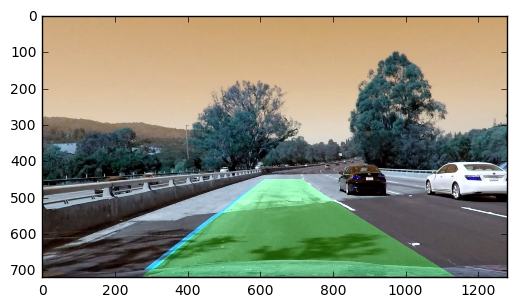

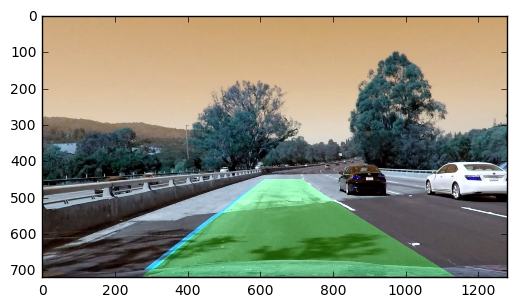

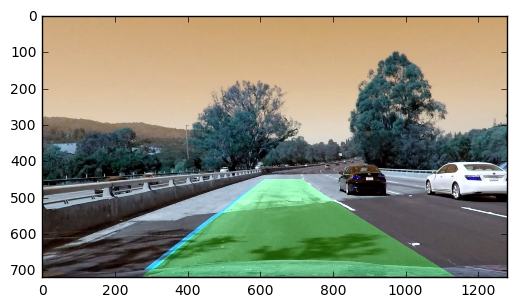

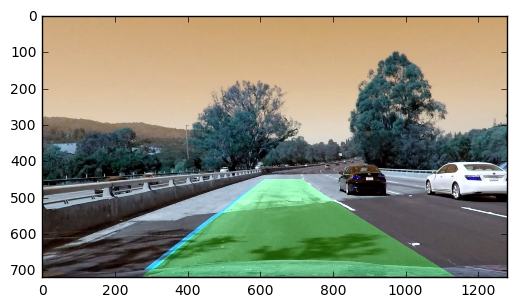

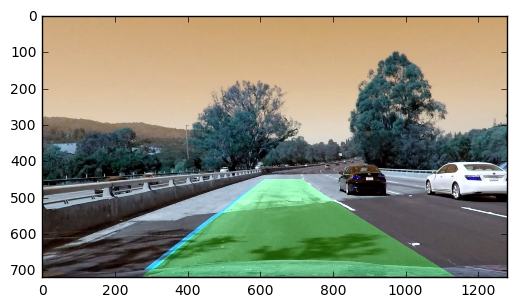

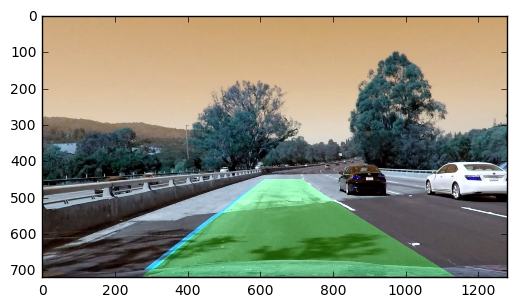

In [22]:
%matplotlib inline
test_images = glob.glob('test_images/test*.jpg')


# Step through the list and search for chessboard corners
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    lane_line_img = detect_lane_line(img)
    plt.figure()
    plt.imshow(result)
    
    

In [24]:
# test on videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
white_output = 'normal.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(detect_lane_line) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video normal.mp4
[MoviePy] Writing video normal.mp4


 22%|██▏       | 274/1261 [07:16<26:56,  1.64s/it]

KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))